# Project Proposal 

### Introduction
Attending university is an important stage of one’s academic journey. However, not every student obtains a degree, in which their dropout can be caused by a variety of factors. Predicting chances for academic success can be vital towards the future of both the student and university in considering whether the student should continue their studies. The dataset “Predict students' dropout and academic success” contains different factors, such as students’ gender and grades, that may contribute towards students’ status of becoming a graduate or a dropout. The goal is to see if students’ gender, age at enrollment, first year’s first and second semester grades are collectively a good predictor in determining the academic status of university students (graduate or dropout).  

In [1]:
# load necessary packages
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(cowplot)

#library(repr) not needed?

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#set seed for the analysis to be reproducible
set.seed(1)

In [3]:
#load data into R and tidy and wrangle it for our analysis
data_set<- read_delim("https://zenodo.org/record/5777340/files/dataset.csv?download=1", delim = ";")
my_data <- data_set |> 
    select(`Gender`, `Age at enrollment`, `Curricular units 1st sem (grade)`, 
           `Curricular units 2nd sem (grade)`, `Target`) |>
    filter(Target != "Enrolled") |>
    mutate(Target = factor(Target, levels = c("Dropout", "Graduate")))
# could we also mutate grades into percentages by multiplying their values by 5 (since it's out of 20)?
colnames(my_data) <- c('gender', 'enrollment_age', 'first_semester_grade', 'second_semester_grade', 'status') # rename

head(my_data)

Rows: 4424 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr  (1): Target
dbl (34): Marital status, Application mode, Application order, Course, Dayti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gender,enrollment_age,first_semester_grade,second_semester_grade,status
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,20,0.00000,0.00000,Dropout
1,19,14.00000,13.66667,Graduate
1,19,0.00000,0.00000,Dropout
0,20,13.42857,12.40000,Graduate
0,45,12.33333,13.00000,Graduate
1,50,11.85714,11.50000,Graduate


In [4]:
# split data, create training data and testing data
data_split <- initial_split(my_data, prop = 0.2, strata = status) # why prop=0.2 (20%)- isn't that too low?
data_train <- training(data_split)   
data_test <- testing(data_split)

In [5]:
# produce a summary table, grouped by target
summary_table <- data_train |>
    group_by(status) |>
    summarize(status_count = n(),
              female_count = sum(gender == 0),
              male_count = sum(gender == 1),
              mean_enrollment_age = mean(enrollment_age, na.rm = TRUE),
              mean_first_semester_grade = mean(first_semester_grade, na.rm = TRUE),
              mean_second_semester_grade = mean(second_semester_grade, na.rm = TRUE),
              missing_data = sum(is.na(enrollment_age), is.na(first_semester_grade), is.na(second_semester_grade)))
summary_table

status,status_count,female_count,male_count,mean_enrollment_age,mean_first_semester_grade,mean_second_semester_grade,missing_data
<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
Dropout,284,150,134,26.46127,7.286633,5.871582,0
Graduate,441,328,113,21.85488,12.441531,12.448759,0


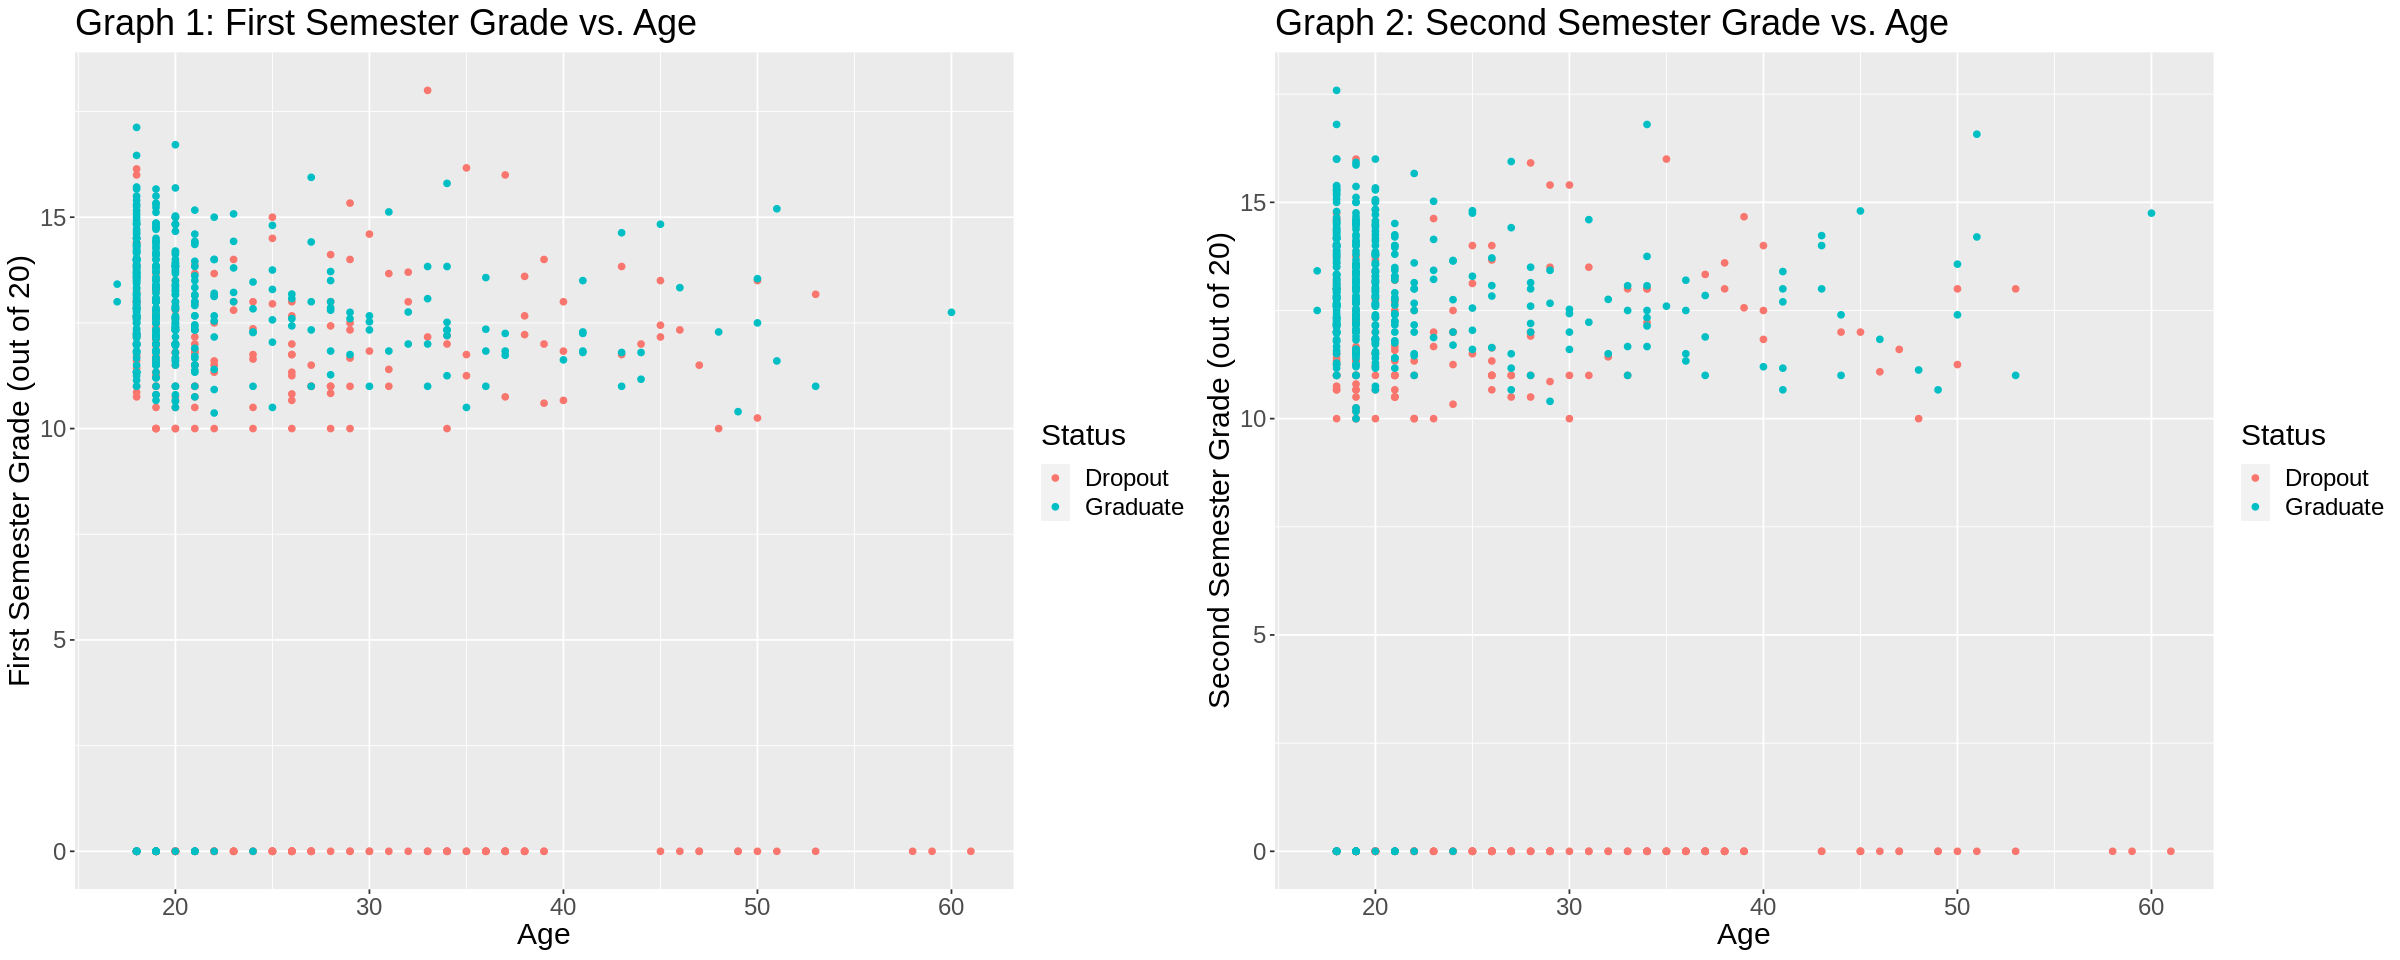

In [15]:
# graph 1: first semester grade vs. age 
# graph 2: second semester grade vs. age

options(repr.plot.width = 20, repr.plot.height = 8)
plot_one <- ggplot(data_train,
                   aes(x = enrollment_age, y = first_semester_grade, colour = status)) +
                           geom_point() +
                           labs(x = "Age", y = "First Semester Grade (out of 20)", title = "Graph 1: First Semester Grade vs. Age",
                                colour = "Status") +
                           theme(text = element_text(size = 18))
plot_two <- ggplot(data_train,
                   aes(x = enrollment_age, y = second_semester_grade, colour = status)) +
                           geom_point() + 
                           labs(x = "Age", y = "Second Semester Grade (out of 20)", title = "Graph 2: Second Semester Grade vs. Age",
                                colour = "Status") +
                           theme(text = element_text(size = 18))
plot_grid(plot_one, plot_two)

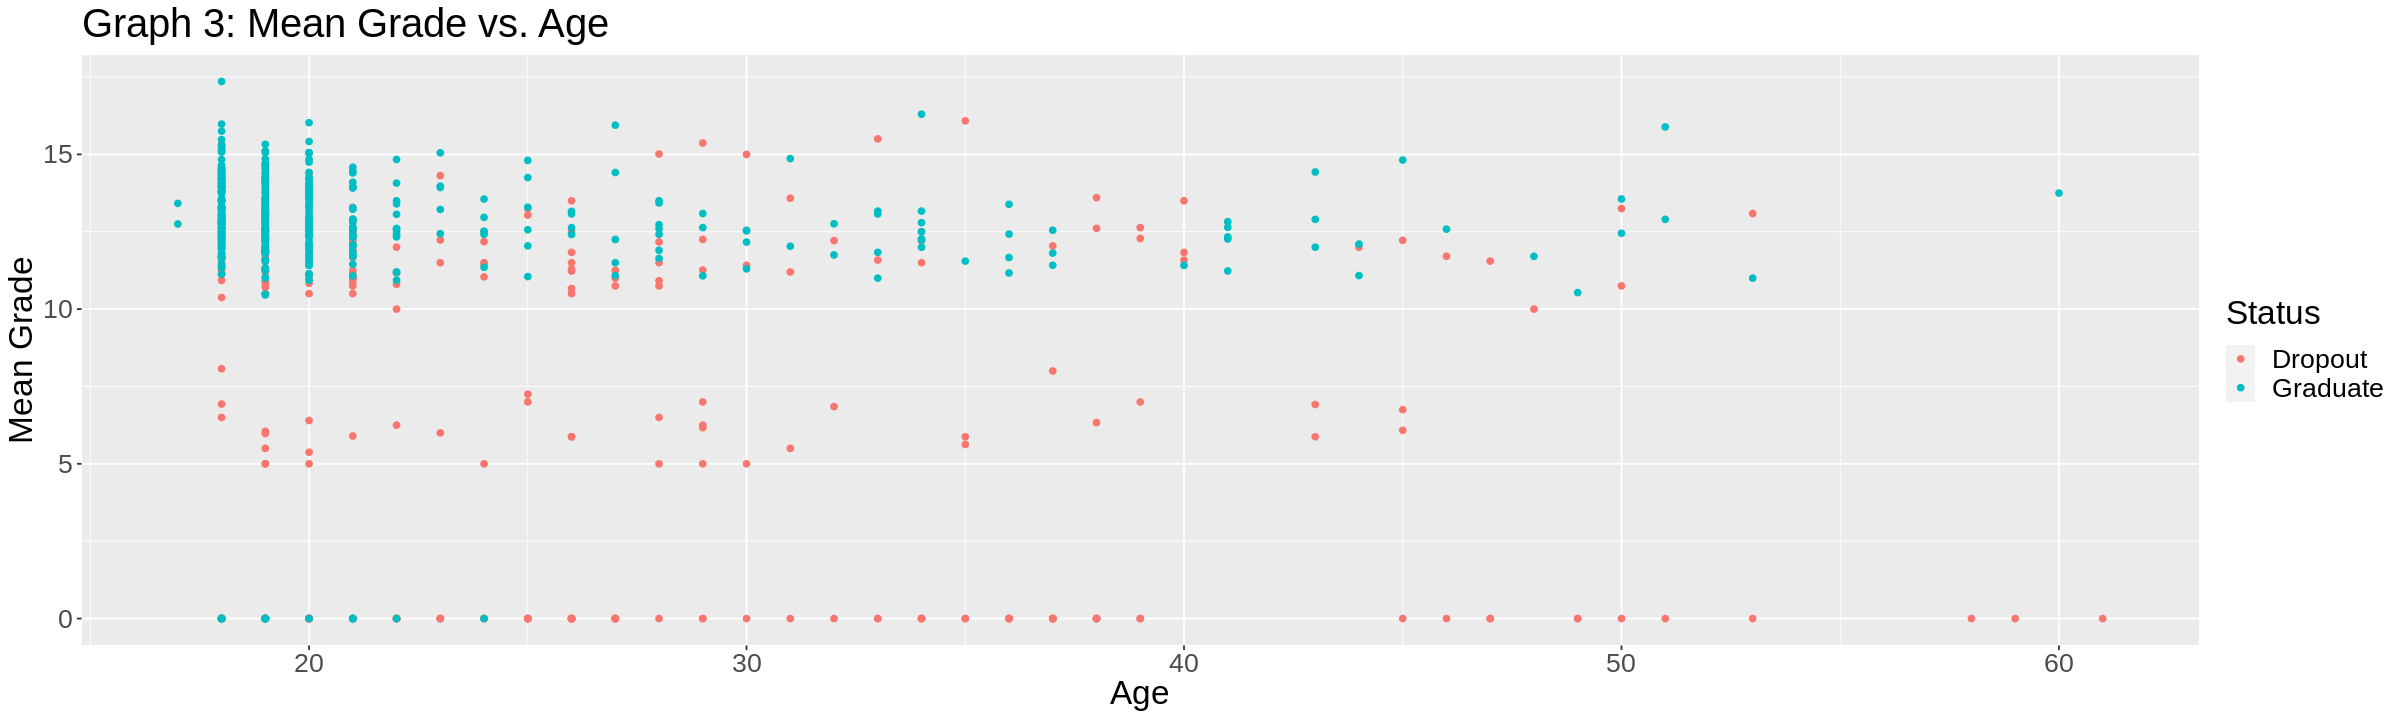

In [18]:
# graph3: mean grade for the first and second semesters vs. age

options(repr.plot.width = 20, repr.plot.height = 6)

mean_grade_plot <- data_train |>
    mutate(mean_sem_grade = (first_semester_grade + second_semester_grade) / 2) |>
    ggplot(aes(x = enrollment_age, y = mean_sem_grade, colour = status)) +
    geom_point() +
    labs(x = "Age", y = "Mean Grade", title = "Graph 3: Mean Grade vs. Age",
         colour = "Status") +
    theme(text = element_text(size = 20))
mean_grade_plot

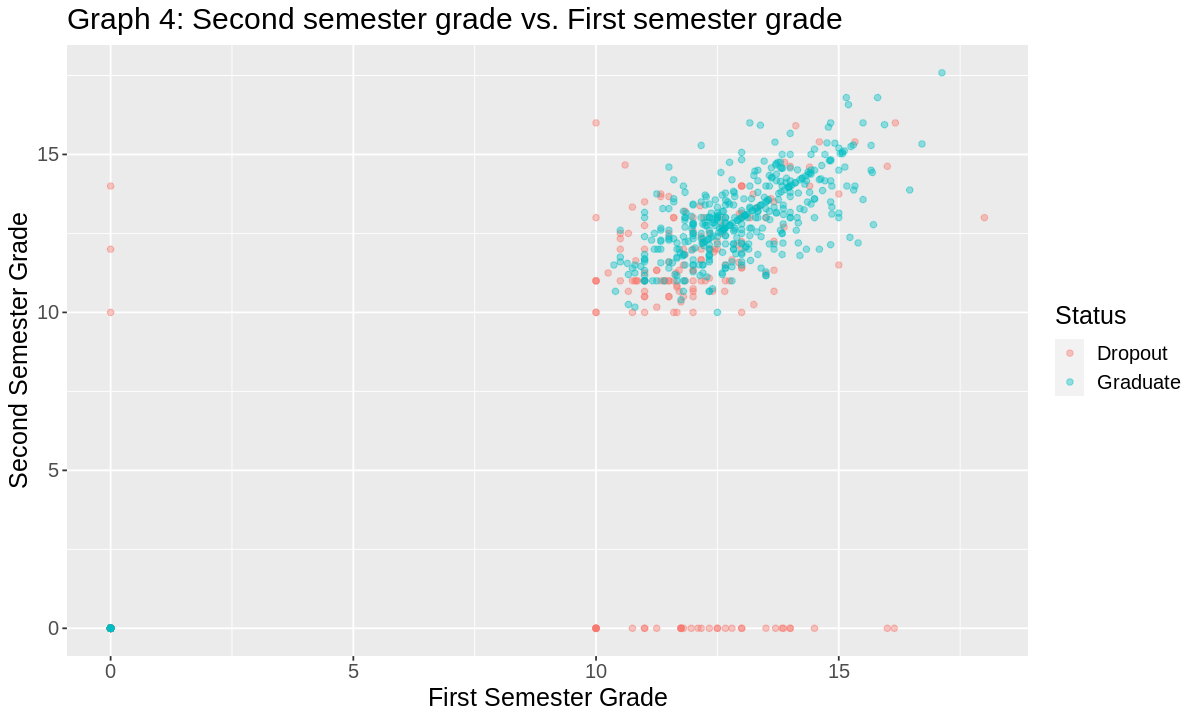

In [19]:
# graph 4: second semester grade vs. first semester grade
options(repr.plot.width = 10, repr.plot.height = 6)
grade_plot <- ggplot(data_train, 
                     aes(x = first_semester_grade, y = second_semester_grade, colour = status)) +
    geom_point(alpha = 0.4) +
    labs(x = "First Semester Grade", y = "Second Semester Grade", 
         title = "Graph 4: Second semester grade vs. First semester grade",
         colour = "Status") +
    theme(text = element_text(size = 15))
grade_plot

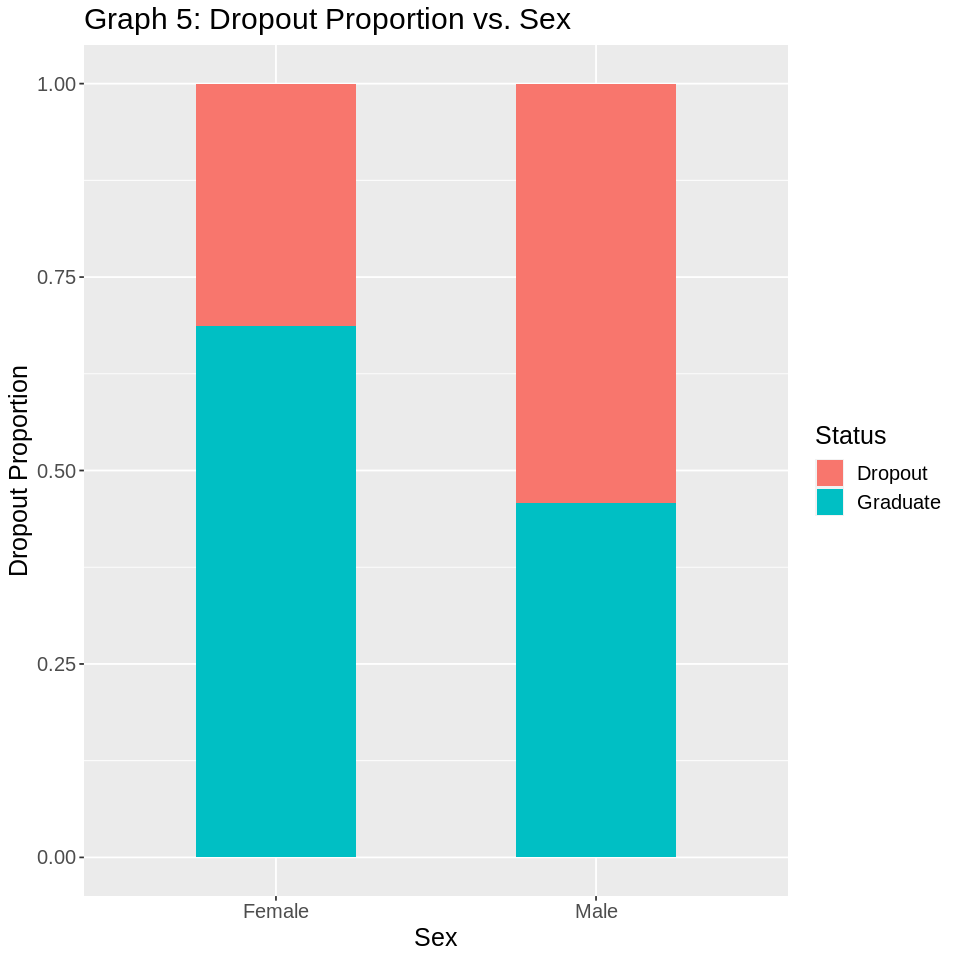

In [20]:
# graph 5: dropout proportion vs. sex
options(repr.plot.width = 8, repr.plot.height = 8)
proportion_bar_plot <- data_train |>
   mutate(gender = factor(gender, levels = c("0", "1"), labels = c("Female", "Male"))) |>
   ggplot(aes(x = gender, fill = status)) + 
   geom_bar(position = 'fill', width = 0.5) + 
   xlab("Sex") +
   ylab("Dropout Proportion") +
   labs(fill = "Status") +
   ggtitle("Graph 5: Dropout Proportion vs. Sex") +
   theme(text = element_text(size = 15))         
proportion_bar_plot

## Methods
#### 1. Choosing Predictors
Four characteristics that may predict whether an individual will be a graduate or a dropout were chosen.

##### Gender
Studies have shown that females are more likely to graduate than males. (source: https://www.brookings.edu/blog/up-front/2021/10/08/the-male-college-crisis-is-not-just-in-enrollment-but-completion/)

##### Age at Enrollment
Differences in experience and maturity of older ages may contribute to better academic performance.

##### 1st & 2nd Semester Grades (2 predictors)
Grades could be a predictor, as low grades can result in students choosing to drop out. Changes in grades from first to second semester could also influence students' decision of dropping out.  

The goal is to see if these predictors do indeed predict whether an individual will graduate or drop out and how well it predicts it.

#### 2. Tidying & Wrangling Data
1. Select the 4 columns of interest in the data set, and rename them to a more human-readable form. 
2. Filter out NAs and rows with "Enrolled" as this is a label for students still studying. 
3. Convert the Target vector to a factor from a character.


#### 3. Training Data + Selecting Parameter Value
1. Split the tidied data set into a training and testing dataset. 
2. Create a recipe specifying the label and predictors' columns and standardize the training dataset. 
3. Tune the model using the KNN algorithm and 5-fold validation to pick the best K value
4. Perform a workflow analysis to fit the model for k values of 1-10.
5. Collect the estimated accuracies of each classifier created and create a scatter plot graph to choose the best K value. 
6. Retrain the training dataset with the chosen K value. 

#### 4. Evaluating Accuracy of Training Dataset + Conclusion
1. Test the trained model with the testing dataset.
2. Determine classifier’s accuracy.  

### Expected outcomes and significance
We expect the four chosen factors to collectively predict fairly well whether a student will be a graduate or a dropout. If there is indeed a correlation and the factors are collectively a good predictor, the created classifier could be used by students with matching factors to predict whether they will become a graduate or a dropout. Further studies could be done to analyze each factor’s significance on predicting students' future status (graduate or dropout) and determining why certain factor(s) could be more significant. If the classifier is high in accuracy, another question could be whether or not this model can be applied to elementary and high school students.